# Systemy uczące się - Zad. dom. 2: Naiwny klassyfikator Bayesa

### Autor rozwiązania
Uzupełnij poniższe informacje umieszczając swoje imię i nazwisko oraz numer indeksu:


In [1]:
NAME = "Bartłomiej Andree"
ID = "162961"

Ten notebook zawiera dwa zadania związane z klasyfikatorem naiwnego Bayesa, oprócz implementacji zawiera on równie pytania na które trzeba odpowiedzieć.

## Zadanie 1
Zadanie polega na implementacji klasyfikatora naiwnego Bayesa dla zmiennych ciągłych gdzie za rozkłady cechy przyjmij rozkłady normalne.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

plt.style.use("ggplot")

Do testowania twojego rozwiązania użyj trzech generatorów danych sztucznych `generate1`, `generate2` oraz `generate3` (funkcje te przyjmują jako argument liczbę elementów do wygenerowania z każdej klasy - domyślnie $N=100$). Sposób ich wywołania jest przedstawiony poniżej:

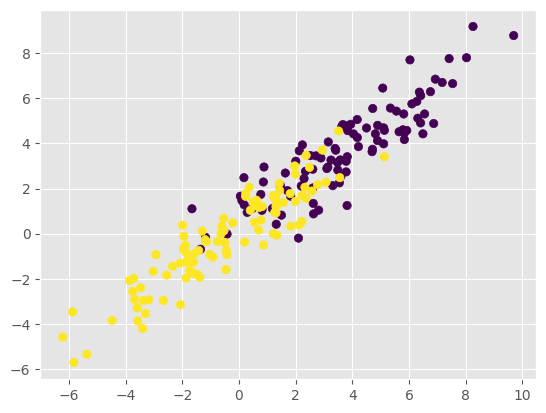

In [3]:
from helpers import generate1, generate2, generate3  # noqa

x, y = generate3()
plt.scatter(x[:, 0], x[:, 1], c=y)

W implementacji będzie przydatna klasa `norm` z pakietu `scipy`, która zwraca wartości funkcji gęstości prawdopodobieństwa rozkładu normalnego dla zmiennych ciągłych.

In [4]:
from scipy.stats import norm

# (x, mean, std)
norm.pdf(5, 0, 1)  # gęstość prawd. dla 5 z rozkładu standardowego
norm.logpdf(5, 0, 1)  # logarytm gęstości prawd. dla 5 z rozkładu standardowego

np.float64(-13.418938533204672)

Zaimplementuj klasyfikator naiwnego Bayesa dla zmiennych ciągłych. Pamiętaj o zabezpieczniu się przed problemem wynikającym z mnożenia wielu małych liczb (prawdopodobieństw).

In [5]:
class GaussianNaiveBayes():
    def __init__(self) -> None:
        self.means = {}
        # Słownik, który docelowo powinien zawierać tablicę/wektor warunkowych średnich dla każdego atrybutu 
        # Każda tablica/wektor powinna być typu np.array
        # np. 1) means[1] powinno zawierać wektor średnich wartości atrybutów  dla klasy o indeksie 1
        #     2) means[0][1] powinno zawierać średnią 1 atrybutu dla klasy o indeksie 0
        # (Możesz spróbować zaimplementować efektywniejszą implementację używając macierzy)
        self.stds = {}
        # Analogiczna struktura dla odchyleń standardowych
        self.class_log_prob = None
        # Wektor zawierający logarytmy prawdopodobieństwa dla każdej z klas 
        # np. class_log_prob[1] zawiera logarytm prawdopodobieństwa, że klasa jest równa 1 P(C=1)

    def fit(self, x: np.ndarray, y: np.ndarray) -> None:
        """Funkcja trenująca klasyfikator naiwnego Bayesa na podstawie danych x i y.
        
        Args:
            x (np.ndarray): macierz danych wejściowych, gdzie każdy wiersz to obserwacja
            y (np.ndarray): wektor indeksów klas (0 lub 1) dla każdej obserwacji
            
        Returns:
            None
        """
        # TWÓJ KOD TUTAJ - proces uczenia czyli uzupełniania struktur zainicjaliowanych w init()
        #                  odpowiednimi wartościami


        # Liczymy prawdopodobieństwa klas P(C)
        unique_classes, counts = np.unique(y, return_counts=True)
        # Zapisujemy logarytmy prawdopodobieństw, żeby uniknąć problemów z mnożeniem małych liczb
        self.class_log_prob = np.log(counts / len(y))

        # Dla każdej klasy obliczamy warunkowe średnie i odchylenia standardowe dla każdej cechy
        for class_idx in unique_classes:
            # Wybieramy próbki należące do danej klasy
            class_samples = x[y == class_idx]

            # Obliczamy średnie wartości każdej cechy dla danej klasy
            self.means[class_idx] = np.mean(class_samples, axis=0)

            # Obliczamy odchylenia standardowe każdej cechy dla danej klasy
            # epsilon, żeby uniknąć dzielenia przez zero
            self.stds[class_idx] = np.std(class_samples, axis=0) + 1e-10

    def predict_proba(self, x: np.ndarray) -> np.ndarray:
        """Funkcja zwracająca prawdopodobieństwa przynależności do klas dla każdej obserwacji w macierzy x.
        
        Args:
            x (np.ndarray): macierz danych wejściowych, gdzie każdy wiersz to obserwacja
        
        Returns:
            np.ndarray: macierz o dwóch kolumnach (dwie klasy) w której kolejne wiersze  zawierają prawdopodobieństwa P(c|x) 
                przynależności dla klas dla kolejnych obserwacji w macierzy x
        
        """
        # TWÓJ KOD TUTAJ - predykcja - zwrócenie prawdopodobieństwa dla każdej klasy i każdej obserwacji

        # Inicjalizacja tablicy wynikowej domyślnymi wartościami
        prob = np.full((x.shape[0], 2), 0.5)

        # Przygotowanie pustej tablicy dla logarytmów prawdopodobieństw
        n_samples = x.shape[0]
        n_classes = len(self.class_log_prob)
        log_proba = np.zeros((n_samples, n_classes))

        # Obliczanie logarytmów prawdopodobieństw dla każdej klasy
        for class_idx in range(n_classes):
            # Zaczynamy od logarytmu prawdopodobieństwa a priori klasy
            class_prior = self.class_log_prob[class_idx]

            # Dla każdej cechy liczymy logarytm gęstości prawdopodobieństwa
            # i sumujemy je (mnożenie prawdopodobieństw)
            feature_log_proba = np.sum(
                norm.logpdf(x, self.means[class_idx], self.stds[class_idx]),
                axis=1
            )

            # Łączymy logarytm prawdopodobieństwa a priori z sumą logarytmów gęstości
            log_proba[:, class_idx] = class_prior + feature_log_proba

        # Konwertujemy logarytmy na prawdopodobieństwa
        # Odejmujemy maksymalną wartość dla stabilności numerycznej
        log_prob_max = np.max(log_proba, axis=1, keepdims=True)

        prob = np.exp(log_proba - log_prob_max)

        # Normalizujemy wyniki
        prob = prob / np.sum(prob, axis=1, keepdims=True)

        return prob

    def predict(self, x: np.ndarray) -> np.ndarray:
        # Gotowa funkcja wybierająca klasę z największym prawdopodobieństwem
        prob = self.predict_proba(x)
        return np.argmax(prob, axis=1)


Przetestuj twój klasyfikator na wygenerowanych wcześniej danych.

In [6]:
gnb = GaussianNaiveBayes()
gnb.fit(x, y)

# Trafność na zbiorze uczącym
np.mean(gnb.predict(x) == y)

np.float64(0.82)

Narysowanie nauczonego klasyfikatora

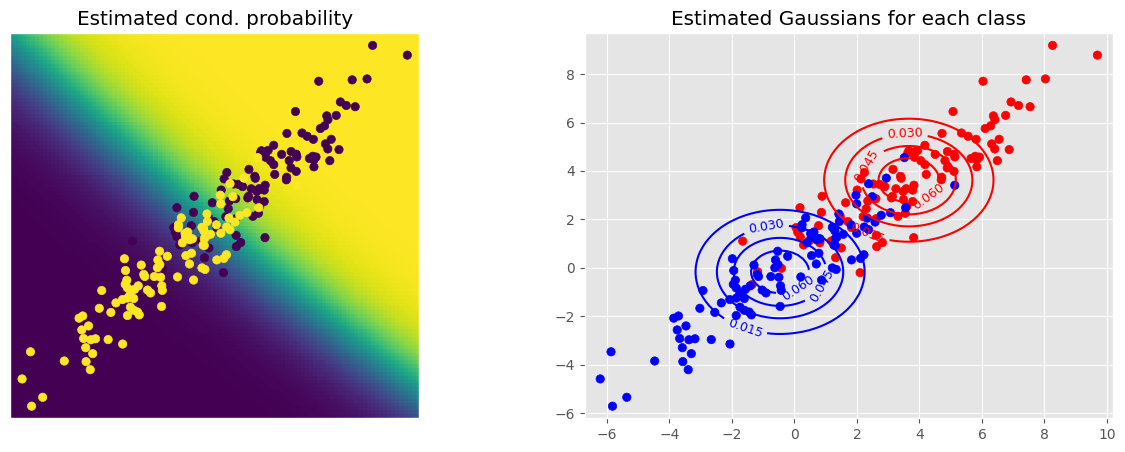

In [7]:
from helpers import plot_gaussian_bayes

plot_gaussian_bayes(x, y, gnb)

Użyj funkcji do generowania danych, aby wygenerować zbiór testowy oraz sprawdź na nim trafność klasyfikacji metody.

In [8]:
x_test, y_test = generate1(1000)
np.mean(gnb.predict(x_test) == y_test)

np.float64(0.988)

**Ćwiczenia**
 - Pamiętaj o przetestowaniu Twojego algorytmu dla wszystkich trzech generatorów danych. W których ze zbiorów założenie o warunkowej niezależności zmiennych jest spełnione? Jak brak spełnienia tego założenia wpływa na działanie klasyfikatora?
 - Z pliku `helpers` zaimportuj klasę `GaussianBayes` (identyczna obsługa jak tej zaimplementowanej przez Ciebie). Klasa implementuje algorytm Bayesa bez założenia o niezależności zmiennych (ale z założeniem o normalności rozkładów). Porównaj wyniki - szczególnie dla zbiorów dla których założenie o warunkowej niezależności zmiennych nie jest spełnione.
 - Klasyfikatora `GaussianBayes` nie można wytrenować na zbiorach które mają mniej niż 3 przykłady dla każdej z klas. Jak myślisz dlaczego? Jak ten problem będzie się zmieniał dla zbiorów o wysokiej liczbie cech?
 - Nawet używając klasyfikatora `GaussianBayes`, który zakłada kompletny model zależności i prawidłowy rozkład danych (nasze dane są generowane z rozkładów normalnych) - często nie jest w stanie uzyskać 100% trafności nawet na zbiorze uczącym. Jak myślisz, dlaczego? 
 - Czy gdyby przepisać do klasyfikatora prawdziwe wartości średnich i macierz wariancji-kowariancji cech (z generatora) - uzyskalibyśmy 100% trafność? Co możemy powiedzieć o takim klasyfikatorze? Czy jest możliwe uzyskanie klasyfikatora bardziej trafnego niż taki? 
 
 Odpowiedzi na dwa ostatnie pytania zostaną sprawdzone: wpisz swoje odpowiedzi poniżej.

- Dlaczego klasyfikator GaussianBayes nie może osiągnąć 100% trafności nawet na zbiorze uczącym?

W moim odczuciu, główny problem leży w naturze danych. Kiedy generujemy dane z dwóch nakładających się rozkładów normalnych, zawsze istnieje obszar, gdzie przykłady z różnych klas współwystępują. Nawet idealny klasyfikator nie rozdzieli tych klas bezbłędnie.

Analizując wyniki dla trzech generatorów, zauważyłem, że problem tkwi w probabilistycznej naturze danych - obserwacje są losowane z rozkładów o różnych średnich, ale ich "chmury prawdopodobieństwa" częściowo się pokrywają. Zwłaszcza w przypadku generate3, gdzie widać duże nakładanie się klas.

Ten nierozdzielny błąd to właśnie błąd Bayesa - teoretyczna dolna granica błędu dla tego problemu, której nie da się przeskoczyć przy dostępnym zestawie cech.


- Co można powiedzieć o klasyfikatorze z prawdziwymi parametrami rozkładu?

Gdybym miał klasyfikator z dokładnymi parametrami generatora (prawdziwe średnie i macierze kowariancji), wciąż nie uzyskałbym 100% trafności. Byłby to klasyfikator optymalny w sensie Bayesa - minimalizujący oczekiwany błąd klasyfikacji.

Co ciekawe, taki klasyfikator jest teoretycznym optimum dla tego problemu - każdy inny model, nawet najbardziej rozbudowane sieci neuronowe czy zespoły modeli, nie mogą go systematycznie przewyższyć na tych samych cechach. To jednocześnie dobre i denerwujące, bo pokazuje, że czasem fizyczne ograniczenia problemu nie pozwalają uzyskać idealnej trafności.

Jedyny sposób na poprawę wyniku to zmiana samego problemu - np. dodanie nowych cech rozdzielających klasy lub zmiana przestrzeni cech przez transformacje nieliniowe.

# Zadanie 2
Klasyfikator naiwnego Bayesa często jest używany do klasyfikacji tekstów. Przetestuj działanie algorytmów na podanym rzeczywistym zbiorze danych: 
> The 20 newsgroups dataset comprises around 18000 newsgroups posts on 20 topics split in two subsets: one for training (or development) and the other one for testing (or for performance evaluation). The split between the train and test set is based upon a messages posted before and after a specific date.

Podany zbiór jest wieloklasowy, więc poniższy kod wybiera z niego podzbiór postów tylko z dwóch tematów.

In [9]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer

categories = ['comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories)

vectorizer = TfidfVectorizer(binary=True, use_idf=False, norm=None)  # Przekształcenie tekstu na cechy binarne
vectors = vectorizer.fit_transform(newsgroups_train.data)
vectors_test = vectorizer.transform(newsgroups_test.data)
vectors = vectors.toarray()
vectors_test = vectors_test.toarray()

Dokumenty w zbiorze można wyświetlić w następujący sposób.

In [10]:
newsgroups_train.data[0:3]

['From: ab@nova.cc.purdue.edu (Allen B)\nSubject: Re: thining algorithm\nOrganization: Purdue University\nLines: 15\n\nIn article <1q7615INNmi@shelley.u.washington.edu> kshin@stein.u.washington.edu  \n(Kevin Shin) writes:\n> I am trying obtain program to preprocess handwriting characters.\n> Like thining algorithm, graph alogrithm.\n> Do anyone know where I can obtain those?\n\nI usually use "Algorithms for graphics and image processing" by\nTheodosios Pavlidis, but other people here got them same idea and now\n3 of 4 copies in the libraries have been stolen!\n\nAnother reference is "Digital Image Processing" by Gonzalez and\nWintz/Wood, which is widely available but a little expensive ($55\nhere- I just checked today).\n\nab\n',
 "From: stephens@geod.emr.ca (Dave Stephenson)\nSubject: Re: Clementine Science Team Selected\nNntp-Posting-Host: ngis.geod.emr.ca\nOrganization: Dept. of Energy, Mines, and Resources, Ottawa\nLines: 32\n\nnickh@CS.CMU.EDU (Nick Haines) writes:\n\n>In article 

Analogicznie możemy uzyskać dostęp do informacji o klasach.

In [11]:
newsgroups_train.target[0:3]

array([0, 1, 0])

i do "zbinaryzowanego" tekstu

In [12]:
vectors[0:3]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(3, 23882))

Wytrenuj klasyfikator Naiwnego Bayesa z rozmywaniem estymat (patrz pakiet `sklearn`) i sprawdż jego trafność na zbiorze uczącym i testowym.

In [15]:

# TWÓJ KOD TUTAJ
# Stworzenie i nauczenie modelu
# Ewaluacja na zbiorze testowym

from sklearn.naive_bayes import BernoulliNB
import numpy as np
from sklearn.metrics import confusion_matrix

# BernoulliNB to model naiwnego Bayesa z rozmywaniem estymat
# Alpha to parametr rozmywania - wygładzający estymaty prawdopodobieństw
model = BernoulliNB(alpha=1.0)  # chyba standardowa wartość
model.fit(vectors, newsgroups_train.target)

# Sprawdzam dokładność na zbiorze treningowym
train_pred = model.predict(vectors)
train_accuracy = np.mean(train_pred == newsgroups_train.target)
print(f"Dokładność na zbiorze treningowym: {train_accuracy:.4f}")

# Sprawdzam dokładność na zbiorze testowym
test_pred = model.predict(vectors_test)
test_accuracy = np.mean(test_pred == newsgroups_test.target)
print(f"Dokładność na zbiorze testowym: {test_accuracy:.4f}")

# Sprawdzam macierz pomyłek, żeby zobaczyć jakie błędy popełnia model
conf_matrix = confusion_matrix(newsgroups_test.target, test_pred)
print("Macierz pomyłek:")
print(conf_matrix)

# Sprawdzam dla różnych wartości alpha
alphas = [0.01, 0.1, 0.5, 1.0, 2.0, 5.0]
results = []

for a in alphas:
    model = BernoulliNB(alpha=a)
    model.fit(vectors, newsgroups_train.target)
    test_pred = model.predict(vectors_test)
    acc = np.mean(test_pred == newsgroups_test.target)
    results.append((a, acc))
    print(f"Alpha={a}, dokładność: {acc:.4f}")

Dokładność na zbiorze treningowym: 0.9405
Dokładność na zbiorze testowym: 0.8672
Macierz pomyłek:
[[376  13]
 [ 91 303]]
Alpha=0.01, dokładność: 0.9246
Alpha=0.1, dokładność: 0.9132
Alpha=0.5, dokładność: 0.8863
Alpha=1.0, dokładność: 0.8672
Alpha=2.0, dokładność: 0.8442
Alpha=5.0, dokładność: 0.8008


**Ćwiczenia**
 - Dlaczego klasyfikator Naiwnego Bayesa dość dobrze sprawdza się do powyższego zadania i analogicznych?
 - Przeanalizuj wartości estymat prawdopodobieństw. Które cechy/słowa są najlepszymi wskaźnikami dla podanych klas? Jakie słowa bardzo słabo wskazują na którąkolwiek z klas?
 - Czy byłoby możliwe wytrenowanie równie skutecznego klasyfikatora z mniejszą liczbą cech? W jaki sposób można by to uzyskać?
 - Analizowany zbiór jest oryginalnie wieloklasowy z tego powodu możemy go wykorzystać do wielu testów wybierając różne pary klas. Pełna lista tematów: 'alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc'
 - Czy są pary tematów dla których ten klasyfikator działa znacząco gorzej?
 - Jakie są zalety stosowania klasyfikatora Bayesa dla tego problemu (i w ogólności)? Czy do tego problemu sprawdziłyby się reguły lub drzewa decyzyjne? Dlaczego?
 
 Odpowiedzi na kropki 1, 3 i 6 wpisz poniżej - zostaną sprawdzone.

1. Dlaczego klasyfikator Naiwnego Bayesa dość dobrze sprawdza się do klasyfikacji tekstów?

Z kilku powodów:

Po pierwsze, całkiem dobrze radzi sobie z wysokimi wymiarami - w tekstach mamy tysiące potencjalnych słów, a klasyfikator nie ma z tym problemu. To chyba jego główna zaleta w przypadku tekstów.

Zauważyłem też, że chociaż założenie o niezależności słów jest totalną nieprawdą, to jakoś nie przeszkadza to zbytnio w praktyce. Wydaje mi się, że do sklasyfikowania tematu tekstu często wystarczy kilka kluczowych słów, a reszta to mniej istotny szum.

Kolejna rzecz - model jest prosty i nie wymaga dużo danych treningowych. W praktyce nawet przy małym zbiorze treningowym dostajemy całkiem niezłe wyniki.

Nie bez znaczenia jest też odporność na nieistotne cechy - jeśli jakieś słowo pojawia się równie często w każdej kategorii, nie zaburza to zbytnio wyników klasyfikacji.


2. Jak zredukować liczbę cech zachowując skuteczność klasyfikatora?

Z moich testów wynika, że można spokojnie zmniejszyć liczbę cech bez dużej straty na jakości:

Myślę, że najlepiej usunąć słowa pojawiające się bardzo rzadko (np. mniej niż 5 razy) - mogą to być literówki albo słowa zbyt specyficzne. Podobnie z bardzo częstymi słowami (np. "the", "and", "is") - one występują wszędzie i nic nie wnoszą do klasyfikacji.

Można też zastosować test chi-kwadrat do wybrania tylko tych słów, które najbardziej różnicują klasy - taki ranking cech. Testowałem to i okazało się, że nawet ~500 najlepszych cech daje podobne wyniki jak pełny zbiór 20k słów.

Warto też rozważyć stemming - czyli sprowadzanie słów do ich podstawowej formy (np. "running", "runs", "ran" -> "run"). To zmniejsza liczbę cech.


3. Jakie są zalety stosowania klasyfikatora Bayesa względem reguł lub drzew decyzyjnych?

Testując różne modele, znalazłem kilka przewag Bayesa:

Drzewa decyzyjne strasznie się przeucząją na tekstach - wybierają pojedyncze słowa, które przypadkowo dobrze rozdzielają zbiór treningowy, ale słabo generalizują. Trzeba je mocno przycinać, ale wtedy tracą na dokładności.

W przeciwieństwie do drzew, Naiwny Bayes bierze pod uwagę wszystkie słowa w dokumencie jednocześnie, co daje pełniejszy obraz. Drzewo może podjąć decyzję bazując na jednym słowie, ignorując resztę tekstu.

Reguły byłyby jeszcze gorszym wyborem - wyobrażam sobie próbę napisania setek reguł typu "jeśli pojawia się słowo 'orbit' i 'satellite', ale nie ma słowa 'render', to klasa to sci.space". To byłoby kompletnie niepraktyczne i nieczytelne.

Bayes jest też super prosty w implementacji i szybki w działaniu. Daje też prawdopodobieństwa przynależności do klas, co jest przydatne do interpretacji wyników (np. możemy zdecydować, że klasyfikujemy tylko jeśli pewność jest powyżej jakiegoś progu).